In [1]:
!pip install seaborn

In [2]:
import pandas as pd
import os

In [3]:
import pandas as pd
from pathlib import Path

# ---------- CONFIG ----------
BASE = "https://raw.githubusercontent.com/DieckmannDaniel/Git_energy_model/refs/heads/main/model_output"

# known files and separators
FILES = {
    "cost_breakdown.csv": "\t",
    "end_use.csv": "\t",
    "energy_output.csv": "\t",
    "gwp_breakdown.csv": "\t",
    "installed_technologies.csv": "\t",
    "losses.csv": "\t",
    "monthly_operation.csv": "\t",
    "performance.csv": "\t",
    "shares.csv": "\t",
    "storage.csv": "\t",
    "sankey/input2sankey.csv": ",",  # comma-separated, subfolder
}

def download_run_data(run_name: str, base: str = BASE) -> dict:
    """
    Downloads all model CSVs for a given run name into pandas DataFrames.
    Returns a dict like:
    {
        'TOTEX_min_baseline_cost_breakdown': DataFrame,
        'TOTEX_min_baseline_end_use': DataFrame,
        ...
    }
    """
    dfs = {}
    for rel_path, sep in FILES.items():
        url = f"{base.rstrip('/')}/{run_name}/{rel_path}"
        key = f"{run_name}_{Path(rel_path).stem}"  # e.g. TOTEX_min_baseline_cost_breakdown
        try:
            df = pd.read_csv(url, sep=sep, header=0)
            dfs[key] = df
            print(f"✅ Loaded: {key}")
        except Exception as e:
            print(f"[WARN] Could not load {url}: {e}")
    return dfs


In [4]:
if __name__ == "__main__":
    runs = ["TOTEX_min_baseline", "GWP_min_baseline_results"]

    all_data = {}
    for run in runs:
        all_data.update(download_run_data(run))

    # Example access:
    TOTEX_min_baseline_cost_breakdown = all_data["TOTEX_min_baseline_cost_breakdown"]
    display(TOTEX_min_baseline_cost_breakdown.head())

✅ Loaded: TOTEX_min_baseline_cost_breakdown
✅ Loaded: TOTEX_min_baseline_end_use
✅ Loaded: TOTEX_min_baseline_energy_output
✅ Loaded: TOTEX_min_baseline_gwp_breakdown
✅ Loaded: TOTEX_min_baseline_installed_technologies
✅ Loaded: TOTEX_min_baseline_losses
✅ Loaded: TOTEX_min_baseline_monthly_operation
✅ Loaded: TOTEX_min_baseline_performance
✅ Loaded: TOTEX_min_baseline_shares
✅ Loaded: TOTEX_min_baseline_storage
✅ Loaded: TOTEX_min_baseline_input2sankey
✅ Loaded: GWP_min_baseline_results_cost_breakdown
✅ Loaded: GWP_min_baseline_results_end_use
✅ Loaded: GWP_min_baseline_results_energy_output
✅ Loaded: GWP_min_baseline_results_gwp_breakdown
✅ Loaded: GWP_min_baseline_results_installed_technologies
✅ Loaded: GWP_min_baseline_results_losses
✅ Loaded: GWP_min_baseline_results_monthly_operation
✅ Loaded: GWP_min_baseline_results_performance
✅ Loaded: GWP_min_baseline_results_shares
✅ Loaded: GWP_min_baseline_results_storage
✅ Loaded: GWP_min_baseline_results_input2sankey


,Technology,C_inv [MCHF/y],C_maint [MCHF/y]
0,CCGT,88.985174,38.744015
1,PV,299.577580,250.771200
2,WIND,743.561476,169.460000
3,HYDRO_DAM,1905.444566,35.780227
4,HYDRO_RIVER,1140.409501,328.295917


In [5]:
all_data.keys()


dict_keys(['TOTEX_min_baseline_cost_breakdown', 'TOTEX_min_baseline_end_use', 'TOTEX_min_baseline_energy_output', 'TOTEX_min_baseline_gwp_breakdown', 'TOTEX_min_baseline_installed_technologies', 'TOTEX_min_baseline_losses', 'TOTEX_min_baseline_monthly_operation', 'TOTEX_min_baseline_performance', 'TOTEX_min_baseline_shares', 'TOTEX_min_baseline_storage', 'TOTEX_min_baseline_input2sankey', 'GWP_min_baseline_results_cost_breakdown', 'GWP_min_baseline_results_end_use', 'GWP_min_baseline_results_energy_output', 'GWP_min_baseline_results_gwp_breakdown', 'GWP_min_baseline_results_installed_technologies', 'GWP_min_baseline_results_losses', 'GWP_min_baseline_results_monthly_operation', 'GWP_min_baseline_results_performance', 'GWP_min_baseline_results_shares', 'GWP_min_baseline_results_storage', 'GWP_min_baseline_results_input2sankey'])

# Functions

## CAPEX/GWP Comparison

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, Iterable, Optional, Tuple

def compare_performance(
    all_data: Dict[str, pd.DataFrame],
    models: Optional[Iterable[str]] = None,
    figsize: Tuple[float, float] = (11, 4.5),
    show: bool = True,
    return_summary: bool = True,
):
    """
    Build a summary table of CAPEX/OPEX/TOTEX and GWP, and plot two stacked bar charts:
    (1) Costs (CAPEX + OPEX) and (2) GWP (construction + operation).

    Parameters
    ----------
    all_data : dict[str, pd.DataFrame]
        Mapping of model-key -> performance DataFrame.
        Each performance DataFrame should contain an "indicator" column (case-insensitive)
        and numeric columns for CAPEX/OPEX/TOTEX/GWP_*.
    models : iterable[str] or None
        Keys in `all_data` to compare. If None, compares all keys in insertion order.
    figsize : (w, h)
        Size of the matplotlib figure.
    show : bool
        If True, calls plt.show().
    return_summary : bool
        If True, returns the summary DataFrame along with (fig, axes).

    Returns
    -------
    (fig, (ax_cost, ax_gwp)) or (fig, (ax_cost, ax_gwp), summary_df)
    """
    # --- helpers ---
    def grab_metrics(df: pd.DataFrame) -> dict:
        """Return CAPEX/OPEX/TOTEX and GWP parts from a performance table."""
        # find indicator column, drop any repeated header rows
        ind = next((c for c in df.columns if "indicator" in c.lower()), df.columns[0])
        clean = df[df[ind].astype(str).str.lower() != "indicator"].copy()

        # pick the first non-indicator column that has numbers
        val_cols = [c for c in df.columns if c != ind]

        def get(indicator, default=0.0):
            rows = clean[clean[ind].astype(str).str.strip() == indicator]
            if rows.empty:
                return default
            for c in val_cols:
                s = pd.to_numeric(rows[c], errors="coerce")
                if s.notna().any():
                    return float(s.dropna().iloc[0])
            return default

        return {
            "CAPEX [MCHF/y]":               get("CAPEX"),
            "OPEX [MCHF/y]":                get("OPEX"),
            "TOTEX [MCHF/y]":               get("TOTEX"),
            "GWP_construction [ktCO2e/y]":  get("GWP_construction"),
            "GWP_op [ktCO2e/y]":            get("GWP_op"),
            "GWP_total [ktCO2e/y]":         get("GWP_total"),
        }

    # --- select models to use ---
    if models is None:
        models = list(all_data.keys())
    else:
        models = list(models)

    # --- retrieve & summarize ---
    rows = []
    labels = []
    for key in models:
        df = all_data[key]
        # label: strip trailing "_performance" if present
        label = key[:-12] if key.endswith("_performance") else key
        labels.append(label)
        m = grab_metrics(df)
        m["Model"] = label
        rows.append(m)

    summary = pd.DataFrame(rows).set_index("Model")

    # --- visualize ---
    model_names = summary.index.tolist()
    x = range(len(model_names))
    bar_w = 0.6

    fig, (ax_cost, ax_gwp) = plt.subplots(1, 2, figsize=figsize)

    # Costs: CAPEX + OPEX
    capex = summary["CAPEX [MCHF/y]"].astype(float).values
    opex  = summary["OPEX [MCHF/y]"].astype(float).values
    b1 = ax_cost.bar(x, capex, width=bar_w)
    b2 = ax_cost.bar(x, opex,  width=bar_w, bottom=capex)
    ax_cost.set_xticks(list(x))
    ax_cost.set_xticklabels(model_names, rotation=0)
    ax_cost.set_title("Costs (CAPEX + OPEX)")
    ax_cost.set_ylabel("MCHF / year")
    ax_cost.legend([b1, b2], ["CAPEX", "OPEX"], loc="upper left")
    ax_cost.grid(axis="y", linestyle=":", alpha=0.5)

    # GWP: construction + operation
    gwp_c = summary["GWP_construction [ktCO2e/y]"].astype(float).values
    gwp_o = summary["GWP_op [ktCO2e/y]"].astype(float).values
    g1 = ax_gwp.bar(x, gwp_c, width=bar_w)
    g2 = ax_gwp.bar(x, gwp_o, width=bar_w, bottom=gwp_c)
    ax_gwp.set_xticks(list(x))
    ax_gwp.set_xticklabels(model_names, rotation=0)
    ax_gwp.set_title("GWP (construction + operation)")
    ax_gwp.set_ylabel("ktCO₂e / year")
    ax_gwp.legend([g1, g2], ["GWP construction", "GWP operation"], loc="upper left")
    ax_gwp.grid(axis="y", linestyle=":", alpha=0.5)

    plt.tight_layout()
    if show:
        plt.show()

    return (fig, (ax_cost, ax_gwp), summary) if return_summary else (fig, (ax_cost, ax_gwp))


## Create Table of Installed Capacities

In [ ]:
import pandas as pd
from pathlib import Path
import os


def compare_installed_technologies(model_1: str, model_2: str, cap_col: str = "Installed capacity [GW]"):
    """
    Compare installed technologies between two model outputs.

    Parameters
    ----------
    model_1 : str
        Name of the first model (folder under ../model_output/).
    model_2 : str
        Name of the second model (folder under ../model_output/).
    cap_col : str, optional
        Column name for installed capacity (default: "Installed capacity [GW]").

    Returns
    -------
    merged : pandas.DataFrame
        DataFrame with installed capacities for both models, aligned by technology
        and ordered by a predefined list of technologies.
    """

    # -----------------------------
    # 1) Define paths
    # -----------------------------
    f1 = Path(f"../model_output/{model_1}/installed_technologies.csv")
    f2 = Path(f"../model_output/{model_2}/installed_technologies.csv")

    if not f1.exists():
        raise FileNotFoundError(f"Missing file: {f1}")
    if not f2.exists():
        raise FileNotFoundError(f"Missing file: {f2}")

    # -----------------------------
    # 2) Define technology order
    # -----------------------------
    tech_order = [
        "IND_BOILER_GAS", "IND_BOILER_OIL", "IND_HEATER_ELEC", "DEC_BOILER_GAS", "DEC_BOILER_OIL",
        "DEC_HEATER_ELEC", "CAR_GASOLINE", "CAR_DIESEL", "CAR_NG", "CAR_PHEV", "CAR_BEV", "CAR_FC",
        "BUS_DIESEL", "BUS_NG", "BUS_FC", "TRAIN_PUBLIC", "TRAIN_FREIGHT",
        "TRUCK_FREIGHT_DIESEL", "TRUCK_FREIGHT_FC", "CCGT", "CCGT_CCS", "COAL_COMBUSTION",
        "COAL_IGCC", "COAL_COMBUSTION_CCS", "COAL_IGCC_CCS", "IND_BOILER_COAL", "NUCLEAR",
        "IND_COGEN_GAS", "DEC_COGEN_GAS", "DEC_COGEN_OIL", "DHN_COGEN_GAS", "DHN_BOILER_GAS",
        "DHN_BOILER_OIL", "DEC_HP_ELEC", "DHN_HP_ELEC", "DEC_THERMAL_HP_GAS", "GEOTHERMAL_ELEC",
        "DHN_GEOTHERMAL", "HYDRO_DAM", "HYDRO_RIVER", "WIND", "PV", "THERMAL_SOLAR",
        "IND_BOILER_WOOD", "IND_BOILER_WASTE", "IND_COGEN_WOOD", "IND_COGEN_WASTE",
        "DHN_BOILER_WOOD", "DEC_BOILER_WOOD", "DHN_COGEN_WOOD", "DHN_COGEN_WASTE",
        "GASIFICATION_SNG", "PYROLYSIS", "DEC_COGEN_H2", "H2_ELECTROLYSIS", "H2_FROM_GAS",
        "H2_FROM_BIOMASS", "P2G_STORAGE", "P2G_INVESTMENT", "POWER_TO_GAS_EFF", "GAS_TO_POWER_EFF"
    ]

    # -----------------------------
    # 3) Read CSVs
    # -----------------------------
    a = pd.read_csv(f1, sep="\t")
    b = pd.read_csv(f2, sep="\t")

    # -----------------------------
    # 4) Select and rename columns
    # -----------------------------
    model1_name = os.path.basename(os.path.dirname(f1))
    model2_name = os.path.basename(os.path.dirname(f2))

    a_sel = a[["Technology", cap_col]].rename(columns={cap_col: model1_name})
    b_sel = b[["Technology", cap_col]].rename(columns={cap_col: model2_name})

    # -----------------------------
    # 5) Merge
    # -----------------------------
    merged = pd.merge(a_sel, b_sel, on="Technology", how="outer")

    # -----------------------------
    # 6) Reorder by tech_order
    # -----------------------------
    merged = merged.set_index("Technology").reindex(tech_order).reset_index()

    # -----------------------------
    # 7) Drop empty rows
    # -----------------------------
    merged = merged.dropna(subset=[model1_name, model2_name], how="all")

    # -----------------------------
    # 8) Rename and return
    # -----------------------------
    merged = merged.rename(columns={"Technology": "Technology"})

    return merged

## Make Sankey

In [88]:
# sankey_from_csv.py
# Function version: create an interactive Sankey diagram given a model name.

from pathlib import Path
import pandas as pd
import plotly.graph_objects as go


def make_sankey(model_name: str):
    """
    Create and display an interactive Sankey diagram from:
      ../model_output/{model_name}/sankey/input2sankey.csv

    Parameters
    ----------
    model_name : str
        Name of the model/run folder to load the CSV from.

    Returns
    -------
    fig : plotly.graph_objects.Figure
        The Sankey diagram figure.
    """

    # -----------------------------
    # 1) Load CSV
    # -----------------------------
    csv_path = Path(f"../model_output/{model_name}/sankey/input2sankey.csv")
    if not csv_path.exists():
        raise FileNotFoundError(f"CSV not found at: {csv_path}")

    df = pd.read_csv(csv_path)

    # -----------------------------
    # 2) Detect columns
    # -----------------------------
    possible_sources = ["source", "from", "src", "origin", "start", "left"]
    possible_targets = ["target", "to", "dst", "destination", "end", "right"]
    possible_values = ["value", "weight", "amount", "count", "size", "flow", "volume"]

    def find_col(possible, columns):
        lower_map = {c.lower(): c for c in columns}
        for name in possible:
            if name in lower_map:
                return lower_map[name]
        # fuzzy match
        for c in columns:
            if any(name in c.lower() for name in possible):
                return c
        return None

    src_col = find_col(possible_sources, df.columns)
    tgt_col = find_col(possible_targets, df.columns)
    val_col = find_col(possible_values, df.columns)

    # Melt if pivoted
    if src_col and (not tgt_col) and df.shape[1] > 2:
        value_cols = [c for c in df.columns if c != src_col]
        melted = df.melt(
            id_vars=[src_col],
            value_vars=value_cols,
            var_name="__target__",
            value_name="__value__"
        )
        melted = melted[melted["__value__"].notna() & (melted["__value__"] != 0)]
        data = melted.rename(columns={src_col: "source", "__target__": "target", "__value__": "value"})
    else:
        # Edge list fallback
        if not src_col or not tgt_col:
            cols = list(df.columns)
            if len(cols) < 2:
                raise ValueError("Need at least two columns for source and target.")
            src_col = src_col or cols[0]
            tgt_col = tgt_col or cols[1]
            if len(cols) >= 3 and val_col is None:
                val_col = cols[2]
        if val_col is None or val_col not in df.columns:
            df["__value__"] = 1
            val_col = "__value__"
        data = df.rename(columns={src_col: "source", tgt_col: "target", val_col: "value"})

    # Clean up
    data = data[["source", "target", "value"]].copy()
    data["value"] = pd.to_numeric(data["value"], errors="coerce").fillna(1)
    data = data[data["value"] > 0]

    if data.empty:
        raise ValueError("No valid (positive) flows found after processing your CSV.")

    # -----------------------------
    # 3) Build node index mapping
    # -----------------------------
    all_nodes = pd.Index(data["source"]).append(pd.Index(data["target"])).unique().tolist()
    node_index = {name: i for i, name in enumerate(all_nodes)}
    data["src_idx"] = data["source"].map(node_index)
    data["tgt_idx"] = data["target"].map(node_index)

    # -----------------------------
    # 4) Create the Sankey diagram
    # -----------------------------
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(width=0.5),
            label=all_nodes,
        ),
        link=dict(
            source=data["src_idx"].tolist(),
            target=data["tgt_idx"].tolist(),
            value=data["value"].tolist(),
            label=[f"{s} → {t}" for s, t in zip(data["source"], data["target"])],
        )
    )])

    fig.update_layout(
        title_text=f"Sankey Diagram: {model_name}",
        font_size=12
    )

    #fig.show()
    return fig


In [122]:
import os
from pathlib import Path
from functools import reduce
import pandas as pd


def aggregate_cinv_across_models(
    models: list,
    cinv_col: str = "C_inv [MCHF/y]",
    file_name: str = "cost_breakdown.csv",
):
    """
    Aggregate 'C_inv [MCHF/y]' by Technology for any number of model outputs.

    Parameters
    ----------
    models : list[str]
        List of model names (each is a folder under ../model_output/).
    cinv_col : str, optional
        Column name to read for investment cost (default: "C_inv [MCHF/y]").
    file_name : str, optional
        File name to read inside each model folder (default: "cost_breakdown.csv").

    Returns
    -------
    merged : pandas.DataFrame
        A table with rows as technologies (ordered by REQUIRED_TECHS)
        and one column per model containing the selected cost metric.
    """

    # -----------------------------
    # 1) Define paths
    # -----------------------------
    paths = {m: Path(f"../model_output/{m}/{file_name}") for m in models}
    missing = [str(p) for p in paths.values() if not p.exists()]
    if missing:
        raise FileNotFoundError(f"Missing file(s): {', '.join(missing)}")

    # -----------------------------
    # 2) Define technology order
    # -----------------------------
    REQUIRED_TECHS = [
        "ELECTRICITY","GASOLINE","DIESEL","OIL","NG","NG_CCS",
        "WOOD","COAL","COAL_CCS","URANIUM","WASTE","H2",
    ]

    # -----------------------------
    # 3) Read CSVs
    # -----------------------------
    # Use sep=None with engine='python' to auto-detect comma/semicolon/tab.
    frames = {
        m: pd.read_csv(p, sep=None, engine="python")
        for m, p in paths.items()
    }

    # -----------------------------
    # 4) Select and rename columns
    # -----------------------------
    selected = []
    for m, df in frames.items():
        if "Technology" not in df.columns or cinv_col not in df.columns:
            raise KeyError(
                f"{paths[m]} must contain columns 'Technology' and '{cinv_col}'. "
                f"Columns found: {list(df.columns)}"
            )
        part = (
            df[["Technology", cinv_col]]
            .rename(columns={cinv_col: m})
        )
        selected.append(part)

    # -----------------------------
    # 5) Merge (N-way outer join on Technology)
    # -----------------------------
    merged = reduce(
        lambda left, right: pd.merge(left, right, on="Technology", how="outer"),
        selected
    )

    # -----------------------------
    # 6) Reorder by REQUIRED_TECHS
    # -----------------------------
    merged = (
        merged.set_index("Technology")
        .reindex(REQUIRED_TECHS)
        .reset_index()
    )

    # -----------------------------
    # 7) Drop empty rows
    # -----------------------------
    value_cols = [c for c in merged.columns if c != "Technology"]
    merged = merged.dropna(subset=value_cols, how="all")

    # -----------------------------
    # 8) Rename and return
    # -----------------------------
    merged = merged.rename(columns={"Technology": "Resources"})
    return merged


# Example usage:
table = aggregate_cinv_across_models(
     models=["TOTEX_min_baseline", "GWP_min_baseline_results"],
     cinv_col="C_inv [MCHF/y]",
     file_name="cost_breakdown.csv",
 )

table


,Resources,TOTEX_min_baseline,GWP_min_baseline_results
1,GASOLINE,392.665881,392.665881
2,DIESEL,449.843180,449.843180
3,OIL,458.004184,NaN
4,NG,3315.398142,NaN
5,NG_CCS,NaN,4560.675000
6,WOOD,NaN,1141.947000
7,COAL,632.938290,NaN
8,COAL_CCS,NaN,1222.963737
10,WASTE,0.000000,0.000000


In [123]:
import pandas as pd

# ---------------------------------------------
# 1) Input data
# ---------------------------------------------
resources = [
    "ELECTRICITY","GASOLINE","DIESEL","OIL","NG","NG_CCS",
    "WOOD","COAL","COAL_CCS","URANIUM","WASTE","H2",
]

cost_no_tax_CHF_kWh = [
    0.09, 0.088, 0.085, 0.079, 0.035, 0.035,
    0.093, 0.03, 0.03, 0.004, 0.0, 0.16
]

carbon_content_kgCO2_kWh = [
    0.01, 0.35, 0.32, 0.31, 0.27, 0.027,
    0.012, 0.4, 0.04, 0.004, 0.15, 0.0
]

tax_CHF_kg_CO2 = [
    0.12, 0.12, 0.12, 0.12, 0.12, 0.0,
    0.0, 0.12, 0.0, 0.0, 0.0, 0.0
]

# ---------------------------------------------
# 2) Build DataFrame
# ---------------------------------------------
df = pd.DataFrame({
    "Resources": resources,
    "cost_no_tax_CHF_kWh": cost_no_tax_CHF_kWh,
    "carbon_content_kgCO2_kWh": carbon_content_kgCO2_kWh,
    "tax_CHF_kg_CO2": tax_CHF_kg_CO2,
})

# ---------------------------------------------
# 3) Compute cost components
# ---------------------------------------------
df["cost_tax_CHF_kWh"] = df["carbon_content_kgCO2_kWh"] * df["tax_CHF_kg_CO2"]
df["total_cost_CHF_kWh"] = df["cost_no_tax_CHF_kWh"] + df["cost_tax_CHF_kWh"]

# ---------------------------------------------
# 4) Display results
# ---------------------------------------------
df.round(6)

# Optional: Save results
# df.to_csv("energy_costs_with_tax.csv", index=False)


,Resources,cost_no_tax_CHF_kWh,carbon_content_kgCO2_kWh,tax_CHF_kg_CO2,cost_tax_CHF_kWh,total_cost_CHF_kWh
0,ELECTRICITY,0.090,0.010,0.12,0.0012,0.0912
1,GASOLINE,0.088,0.350,0.12,0.0420,0.1300
2,DIESEL,0.085,0.320,0.12,0.0384,0.1234
3,OIL,0.079,0.310,0.12,0.0372,0.1162
4,NG,0.035,0.270,0.12,0.0324,0.0674
5,NG_CCS,0.035,0.027,0.00,0.0000,0.0350
6,WOOD,0.093,0.012,0.00,0.0000,0.0930
7,COAL,0.030,0.400,0.12,0.0480,0.0780
8,COAL_CCS,0.030,0.040,0.00,0.0000,0.0300
9,URANIUM,0.004,0.004,0.00,0.0000,0.0040


In [125]:
df_combined = pd.merge(table, df, on="Resources", how="left")

df_combined

,Resources,TOTEX_min_baseline,GWP_min_baseline_results,cost_no_tax_CHF_kWh,carbon_content_kgCO2_kWh,tax_CHF_kg_CO2,cost_tax_CHF_kWh,total_cost_CHF_kWh
0,GASOLINE,392.665881,392.665881,0.088,0.350,0.12,0.0420,0.1300
1,DIESEL,449.843180,449.843180,0.085,0.320,0.12,0.0384,0.1234
2,OIL,458.004184,NaN,0.079,0.310,0.12,0.0372,0.1162
3,NG,3315.398142,NaN,0.035,0.270,0.12,0.0324,0.0674
4,NG_CCS,NaN,4560.675000,0.035,0.027,0.00,0.0000,0.0350
5,WOOD,NaN,1141.947000,0.093,0.012,0.00,0.0000,0.0930
6,COAL,632.938290,NaN,0.030,0.400,0.12,0.0480,0.0780
7,COAL_CCS,NaN,1222.963737,0.030,0.040,0.00,0.0000,0.0300
8,WASTE,0.000000,0.000000,0.000,0.150,0.00,0.0000,0.0000


In [133]:
df_combined = df_combined.apply(pd.to_numeric, errors="ignore")

df_final = pd.DataFrame({
    "Resource": df_combined["Resources"],
    "total_tax_CHF": (df_combined["TOTEX_min_baseline"] / df_combined["total_cost_CHF_kWh"]) * df_combined["cost_tax_CHF_kWh"]
})

df_final





/var/folders/sp/5hpywdg907ncz7h2_zr9lc_80000gn/T/ipykernel_72480/3035684461.py:1: FutureWarning:

errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead



,Resource,total_tax_CHF
0,GASOLINE,126.861285
1,DIESEL,139.983615
2,OIL,146.624403
3,NG,1593.752223
4,NG_CCS,NaN
5,WOOD,NaN
6,COAL,389.500486
7,COAL_CCS,NaN
8,WASTE,NaN


In [134]:
df_final_2 = pd.DataFrame({
    "Resource": df_combined["Resources"],
    "total_tax_CHF": (df_combined["GWP_min_baseline_results"] / df_combined["total_cost_CHF_kWh"]) * df_combined["cost_tax_CHF_kWh"]
})

df_final_2

,Resource,total_tax_CHF
0,GASOLINE,126.861285
1,DIESEL,139.983615
2,OIL,NaN
3,NG,NaN
4,NG_CCS,0.000000
5,WOOD,0.000000
6,COAL,NaN
7,COAL_CCS,0.000000
8,WASTE,NaN


In [140]:
from pathlib import Path
from functools import reduce
import pandas as pd

def summarize_models_with_tax(
    models,
    cinv_col="C_inv [MCHF/y]",
    file_name="cost_breakdown.csv",
    # Optional: override the resource pricing/tax table (must include columns shown below)
    resource_pricing_df: pd.DataFrame | None = None,
):
    """
    Build a single table with:
      - per resource: total_cost_CHF_kWh, cost_tax_CHF_kWh,
      - per resource & model: investment [CHF/y] and implied tax [CHF/y],
      - a final TOTAL row summing investment and tax for each model.

    Parameters
    ----------
    models : list[str]
        Model names (folders under ../model_output/).
    cinv_col : str
        Column to read for investment cost (default: "C_inv [MCHF/y]").
    file_name : str
        Filename to read in each model folder (default: "cost_breakdown.csv").
    resource_pricing_df : pandas.DataFrame | None
        Optional override for resource pricing/tax. If None, built-in defaults are used.
        Expected columns if provided:
          ["Resources", "cost_no_tax_CHF_kWh", "carbon_content_kgCO2_kWh", "tax_CHF_kg_CO2"]

    Returns
    -------
    pandas.DataFrame
        Table with rows = resources plus a TOTAL row.
        Columns:
          - "Resources", "total_cost_CHF_kWh", "cost_tax_CHF_kWh"
          - For each model m:
              m                         (investment CHF/y)
              m__tax_CHF_y              (implied tax CHF/y)
    """
    # ----------------------------- #
    # 1) Define and validate paths  #
    # ----------------------------- #
    paths = {m: Path(f"../model_output/{m}/{file_name}") for m in models}
    missing = [str(p) for p in paths.values() if not p.exists()]
    if missing:
        raise FileNotFoundError(f"Missing file(s): {', '.join(missing)}")

    # ----------------------------- #
    # 2) Resource order (for rows)  #
    # ----------------------------- #
    REQUIRED_TECHS = [
        "ELECTRICITY","GASOLINE","DIESEL","OIL","NG","NG_CCS",
        "WOOD","COAL","COAL_CCS","URANIUM","WASTE","H2",
    ]

    # ----------------------------- #
    # 3) Read model CSVs            #
    # ----------------------------- #
    frames = {
        m: pd.read_csv(p, sep=None, engine="python")
        for m, p in paths.items()
    }

    selected = []
    for m, df in frames.items():
        if "Technology" not in df.columns or cinv_col not in df.columns:
            raise KeyError(
                f"{paths[m]} must contain columns 'Technology' and '{cinv_col}'. "
                f"Columns found: {list(df.columns)}"
            )
        part = df[["Technology", cinv_col]].rename(columns={cinv_col: m})
        selected.append(part)

    # N-way outer join on Technology
    merged = reduce(
        lambda left, right: pd.merge(left, right, on="Technology", how="outer"),
        selected
    )

    # Reorder and cleanup
    merged = (
        merged.set_index("Technology")
              .reindex(REQUIRED_TECHS)
              .reset_index()
              .rename(columns={"Technology": "Resources"})
    )
    value_cols = [c for c in merged.columns if c != "Resources"]
    merged = merged.dropna(subset=value_cols, how="all")

    # --------------------------------------------- #
    # 4) Build (or accept) pricing/tax reference    #
    # --------------------------------------------- #
    if resource_pricing_df is None:
        resources = REQUIRED_TECHS
        cost_no_tax_CHF_kWh = [0.09, 0.088, 0.085, 0.079, 0.035, 0.035, 0.093, 0.03, 0.03, 0.004, 0.0, 0.16]
        carbon_content_kgCO2_kWh = [0.01, 0.35, 0.32, 0.31, 0.27, 0.027, 0.012, 0.4, 0.04, 0.004, 0.15, 0.0]
        tax_CHF_kg_CO2 = [0.12, 0.12, 0.12, 0.12, 0.12, 0.0, 0.0, 0.12, 0.0, 0.0, 0.0, 0.0]

        resource_pricing_df = pd.DataFrame({
            "Resources": resources,
            "cost_no_tax_CHF_kWh": cost_no_tax_CHF_kWh,
            "carbon_content_kgCO2_kWh": carbon_content_kgCO2_kWh,
            "tax_CHF_kg_CO2": tax_CHF_kg_CO2,
        })
    else:
        required_cols = {
            "Resources", "cost_no_tax_CHF_kWh",
            "carbon_content_kgCO2_kWh", "tax_CHF_kg_CO2"
        }
        missing_cols = required_cols - set(resource_pricing_df.columns)
        if missing_cols:
            raise KeyError(f"resource_pricing_df is missing columns: {sorted(missing_cols)}")

    # Compute per-kWh tax and total price
    pricing = resource_pricing_df.copy()
    pricing["cost_tax_CHF_kWh"] = pricing["carbon_content_kgCO2_kWh"] * pricing["tax_CHF_kg_CO2"]
    pricing["total_cost_CHF_kWh"] = pricing["cost_no_tax_CHF_kWh"] + pricing["cost_tax_CHF_kWh"]

    # --------------------------------------------- #
    # 5) Combine & compute model tax in CHF/y       #
    # --------------------------------------------- #
    out = pd.merge(merged, pricing[["Resources", "cost_no_tax_CHF_kWh", "cost_tax_CHF_kWh", "total_cost_CHF_kWh"]], on="Resources", how="left")
    # Ensure numeric for model columns
    for m in models:
        if m in out.columns:
            out[m] = pd.to_numeric(out[m], errors="coerce")

    # For each model, compute implied annual tax (CHF/y)
    for m in models:
        out[f"{m}_tax_CHF"] = (out[m] / out["total_cost_CHF_kWh"]) * out["cost_tax_CHF_kWh"]

    # --------------------------------------------- #
    # 6) Append TOTAL row                           #
    # --------------------------------------------- #
    totals = {"Resources": "TOTAL"}
    # Keep the per-kWh columns blank/NaN for TOTAL
    totals["cost_tax_CHF_kWh"] = pd.NA
    totals["total_cost_CHF_kWh"] = pd.NA
    totals["cost_no_tax_CHF_kWh"] = pd.NA

    for m in models:
        totals[m] = out[m].sum(min_count=1)
        totals[f"{m}_tax_CHF"] = out[f"{m}_tax_CHF"].sum(min_count=1)

    out = pd.concat([out, pd.DataFrame([totals])], ignore_index=True)

    # Column ordering: Resources, per-kWh, then pairs per model
    per_kwh_cols = ["cost_no_tax_CHF_kWh", "total_cost_CHF_kWh", "cost_tax_CHF_kWh"]
    model_cols = []
    for m in models:
        model_cols += [m, f"{m}_tax_CHF"]
    ordered_cols = ["Resources"] + per_kwh_cols + model_cols
    out = out[[c for c in ordered_cols if c in out.columns]]

    return out


# ----------------
# Example usage:
# ----------------
final_table = summarize_models_with_tax(
     models=["TOTEX_min_baseline", "GWP_min_baseline_results"],
     cinv_col="C_inv [MCHF/y]",
     file_name="cost_breakdown.csv",
 )
display(final_table)


/var/folders/sp/5hpywdg907ncz7h2_zr9lc_80000gn/T/ipykernel_72480/1937692490.py:146: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



,Resources,cost_no_tax_CHF_kWh,total_cost_CHF_kWh,cost_tax_CHF_kWh,TOTEX_min_baseline,TOTEX_min_baseline_tax_CHF,GWP_min_baseline_results,GWP_min_baseline_results_tax_CHF
0,GASOLINE,0.088,0.1300,0.0420,392.665881,126.861285,392.665881,126.861285
1,DIESEL,0.085,0.1234,0.0384,449.843180,139.983615,449.843180,139.983615
2,OIL,0.079,0.1162,0.0372,458.004184,146.624403,NaN,NaN
3,NG,0.035,0.0674,0.0324,3315.398142,1593.752223,NaN,NaN
4,NG_CCS,0.035,0.0350,0.0000,NaN,NaN,4560.675000,0.000000
5,WOOD,0.093,0.0930,0.0000,NaN,NaN,1141.947000,0.000000
6,COAL,0.030,0.0780,0.0480,632.938290,389.500486,NaN,NaN
7,COAL_CCS,0.030,0.0300,0.0000,NaN,NaN,1222.963737,0.000000
8,WASTE,0.000,0.0000,0.0000,0.000000,NaN,0.000000,NaN
9,TOTAL,NaN,NaN,NaN,5248.849677,2396.722012,7768.094798,266.844900


# Execution of functions

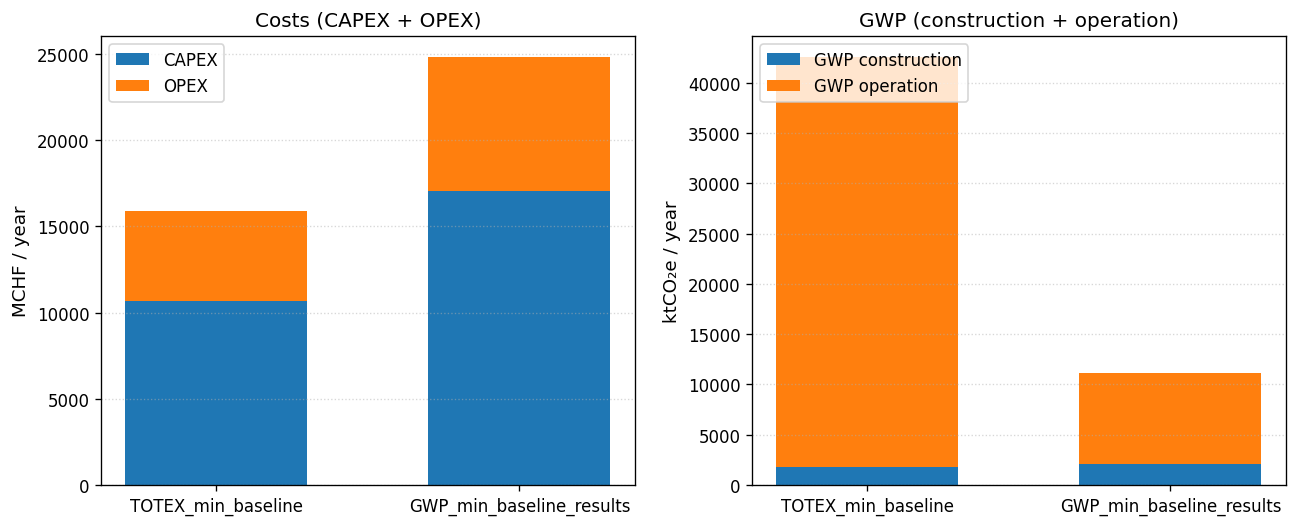

,CAPEX [MCHF/y],OPEX [MCHF/y],TOTEX [MCHF/y],GWP_construction [ktCO2e/y],GWP_op [ktCO2e/y],GWP_total [ktCO2e/y]
Model,,,,,,
TOTEX_min_baseline,10663.18,5248.96,15912.14,1768.57,40739.01,42507.58
GWP_min_baseline_results,17026.55,7768.27,24794.81,2049.20,9134.35,11183.56


In [105]:
# --- example usage ---
fig, (ax_cost, ax_gwp), summary = compare_performance(
     all_data,
     models=[
        "TOTEX_min_baseline_performance",
        "GWP_min_baseline_results_performance",
                  ],
 )
display(summary)

In [106]:
compare_installed_technologies("TOTEX_min_baseline", "GWP_min_baseline_results")

,Technology,TOTEX_min_baseline,GWP_min_baseline_results
0,IND_BOILER_GAS,1.063726,3.948264
2,IND_HEATER_ELEC,NaN,3.161050
3,DEC_BOILER_GAS,13.284044,3.597473
4,DEC_BOILER_OIL,1.967938,1.798737
5,DEC_HEATER_ELEC,NaN,0.489817
6,CAR_GASOLINE,1.184590,1.184590
7,CAR_DIESEL,1.184590,1.184590
8,CAR_NG,0.592295,0.592295
10,CAR_BEV,1.776884,1.776884
11,CAR_FC,1.184590,1.184590


In [89]:
make_sankey("TOTEX_min_baseline")

In [91]:
make_sankey("GWP_min_baseline_results") 

In [107]:
make_sankey("Task4_gwp_i_5_results")

In [108]:
TOTEX_min_baseline_cost_breakdown

,Technology,C_inv [MCHF/y],C_maint [MCHF/y]
0,CCGT,88.985174,38.744015
1,PV,299.577580,250.771200
2,WIND,743.561476,169.460000
3,HYDRO_DAM,1905.444566,35.780227
4,HYDRO_RIVER,1140.409501,328.295917
5,IND_COGEN_WASTE,35.527251,22.952160
6,IND_BOILER_GAS,5.170243,1.340295
7,IND_BOILER_COAL,20.848233,5.395961
8,IND_BOILER_WASTE,9.158847,2.370502
9,DHN_HP_ELEC,6.905652,4.081902
